In [1]:
import warnings
warnings.filterwarnings("ignore")

import gc
from tqdm import tqdm

import numpy as np
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt

import torch
from torch import nn
from cleanlab import Datalab
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from skorch import NeuralNetClassifier

C:\Users\jordan.pierce\.conda\envs\coralnet_classifier\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found cuda


In [ ]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)

device = 'cuda' if torch.cuda.device_count() else 'cpu'
print(f"Found {device}")

In [2]:
class ClassifierModule(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 6, 3),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=-1),
        )

    def forward(self, X):
        X = self.cnn(X)
        X = self.out(X)
        return X

In [3]:
SOURCE_ID = str(4189)

In [4]:
# Root and Source directory
ROOT = "B://CoralNet_Data/"
SOURCE_DIR = ROOT + f"{SOURCE_ID}/"

# Patch dataframe
patches_df = pd.read_csv(SOURCE_DIR + "patches.csv", index_col=0)

subset = False

In [6]:
if subset:

    # Define the number of rows to sample per class
    N = 20

    # Function to sample N rows for each group
    def sample_rows(group):
        return group.sample(N, replace=False)

    # Apply the sampling function to each group
    df = patches_df.groupby('Label').apply(sample_rows).reset_index(drop=True)
    df.reset_index(drop=True, inplace=True)

else:
    df = patches_df.copy()

# Create integer ID value
df['Label ID'] = pd.factorize(df['Label'])[0]

In [7]:
X = []
y = []
data = []

# Loop through each annotation, open patch, store
for i, r in tqdm(df.iterrows()):

    try:
        # Read the patch in
        patch = imread(r['Path']).astype('float32')
        # If it's not the right size...
        if patch.shape[0] != 224 or patch.shape[1] != 224:
            continue
        # Rescale [0-1]
        patch /= 255.0
        # Add to lists
        X.append(patch)
        y.append(r['Label ID'])
        data.append([r['Name'], r['Label']])
    except:
        pass

# Create reponse and predictor variables
X = np.array(X).reshape(len(X), 3, 224, 224)
y = np.array(y).astype('int64')
num_classes = len(np.unique(y))

# Create a new dataframe for later
data = pd.DataFrame(data, columns=['Name', 'Label'])

print(X.shape, y.shape, num_classes)

(43460, 3, 224, 224) (43460,) [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [18]:
model_skorch = NeuralNetClassifier(ClassifierModule(num_classes),
                                   max_epochs=20,
                                   device=device,
                                   batch_size=512)

In [19]:
gc.collect()

num_crossval_folds = 3

pred_probs = cross_val_predict(
    model_skorch,
    X,
    y,
    cv=num_crossval_folds,
    method="predict_proba",
)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.5608       0.5068        1.6737  45.7753
      2        1.3214       0.5039        1.4081  36.4247
      3        1.1867       0.5025        1.4456  83.9513
      4        1.1411       0.5080        1.3504  116.9461
      5        1.1103       0.5177        1.3299  50.0937
      6        1.0711       0.5277        1.2931  41.9839
      7        1.0354       0.5236        1.3006  134.1100
      8        1.0184       0.5389        1.2632  71.2978
      9        0.9748       0.5446        1.2627  57.4342
     10        0.9389       0.6097        1.2297  48.7387
     11        0.8987       0.6123        1.2535  41.7358
     12        0.8637       0.6145        1.2620  54.8578
     13        0.8311       0.6069        1.2655  40.6309
     14        0.7929       0.6257        1.2660  44.0948
     15        0.7595       0.6224        1.2586  49.4120
     16     

In [20]:
predicted_labels = pred_probs.argmax(axis=1)
acc = accuracy_score(y, predicted_labels)

print(f"Cross-validated estimate of accuracy on held-out data: {acc}")

Cross-validated estimate of accuracy on held-out data: 0.5206856879889553


In [21]:
lab = Datalab(data, label_name="Label")
lab.find_issues(pred_probs=pred_probs, issue_types={"label":{}})

lab.report(include_description=False)

Finding label issues ...
Audit complete. 40212 issues found in the dataset.
Here is a summary of the different kinds of issues found in the data:

issue_type  num_issues
     label       40212

Dataset Information: num_examples: 43460, num_classes: 13


----------------------- label issues -----------------------

Number of examples with this issue: 40212
Overall dataset quality in terms of this issue: 0.0319

Examples representing most severe instances of this issue:
       is_label_issue   label_score given_label predicted_label
32659            True  1.247196e-22         ZOA         PorAstr
37745            True  4.487206e-19         ZOA         PorAstr
32369            True  2.944098e-17         ZOA         PorAstr
34068            True  7.963929e-16         ZOA         PorAstr
35085            True  8.277650e-16         ZOA         PorAstr


In [22]:
issue_results = lab.get_issues("label")
issue_results.head(30)

,is_label_issue,label_score,given_label,predicted_label
0,True,0.000488,Sand,CCA1
1,True,0.000074,Turf,CCA1
2,True,0.000001,Turf,CCA1
3,True,0.001718,Sand,CALG
4,True,0.001155,Sand,CCA1
5,True,0.000510,Sand,CCA1
6,True,0.001093,Sand,CCA1
7,True,0.000970,Sand,CCA1
8,True,0.000558,Sand,CCA1
9,True,0.000799,Turf,CCA1


In [23]:
ranked_label_issues = issue_results.sort_values("label_score").index

print(f"Top 15 most likely label errors: \n {ranked_label_issues.values[:15]}")

Top 15 most likely label errors: 
 [32659 37745 32369 34068 35085 34968 31555 35265 31593 39148 40956 32149
 26191 34204 37179]


In [26]:
def plot_examples(id_iter, nrows=1, ncols=1):

    plt.figure(figsize=(30, 100))

    for count, id in enumerate(id_iter):

        plt.subplot(nrows, ncols, count + 1)
        plt.imshow(X[id].reshape(224, 224, 3), cmap="gray")
        plt.title(f"id: {id} \n"
                  f"Given: {issue_results['given_label'][id]} \n "
                  f"Expected: {issue_results['predicted_label'][id]}")

        plt.axis("off")

    plt.tight_layout(h_pad=2.0)

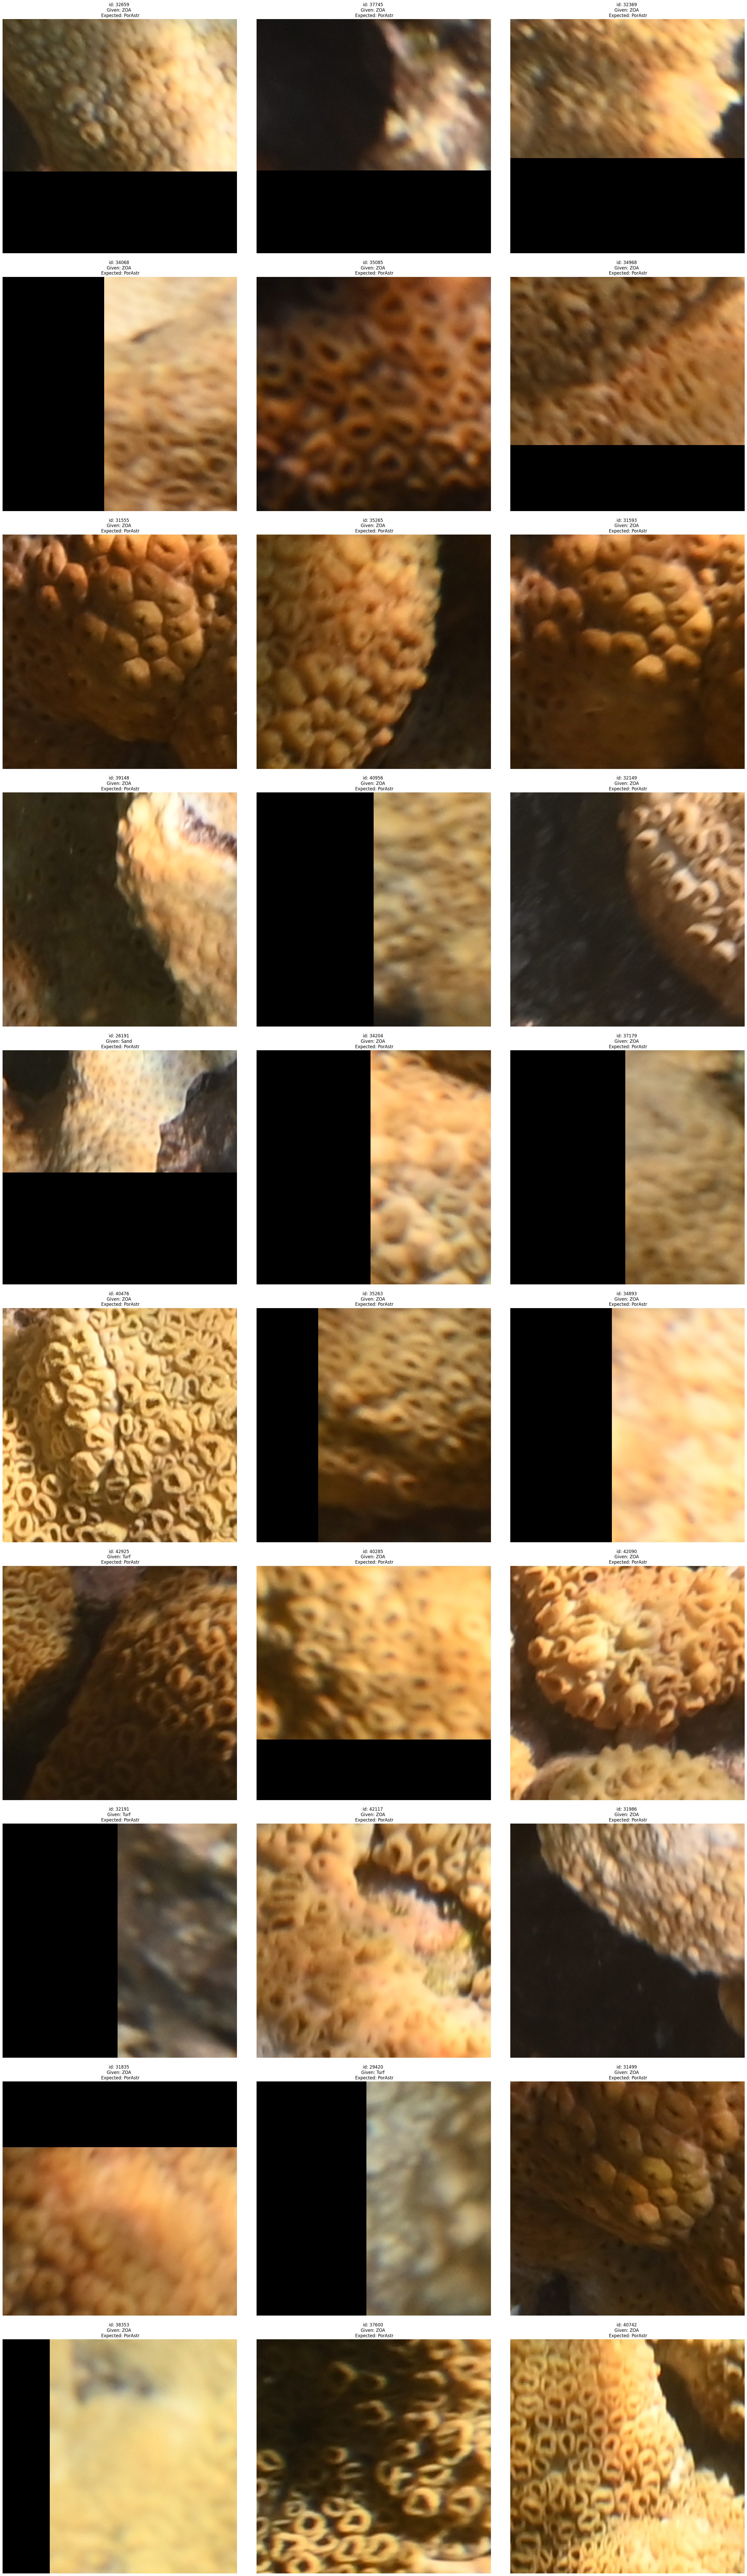

In [27]:
plot_examples(ranked_label_issues[range(30)], 10, 3)